
# Alpha Factor Evaluation

This notebook illustrates the following steps:
- Evaluate the predictive content of your financial features with respect to the 1-day forward returns using several metrics, including:
- the information coefficient (i.e., the Spearman rank correlation)
- the mutual information
- the LightGBM feature importance, computed by training a gradient boosting model with default settings on the first nine years of data 
- SHAP values computed from the LightGBM model (see resources)
- Alphalens quantile-based return spreads (see resources)

These different metrics will yield different and even conflicting answers. Take some time to think about why this is the case, and which approach(es) would likely be most effective when aiming to select the most predictive features?  

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
%matplotlib inline

import os, sys
from time import time

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

import statsmodels.api as sm
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import scale
import lightgbm as lgb
from scipy.stats import spearmanr
import shap

from alphalens.tears import (create_returns_tear_sheet,
                             create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens import plotting
from alphalens import performance as perf
from alphalens import utils

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1).round(1)

In [6]:
MONTH = 21
YEAR = 252

## Load Data

In [7]:
DATA_STORE = '../data/stock_prices.h5'

In [8]:
data = pd.read_hdf('../data/stock_prices.h5', 'model_data')



In [9]:
#NCO
data

ret_01    ret_03    ret_05    ret_10    ret_21    ret_42  \
ticker date                                                                     
A      2006-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
       2006-01-04  0.002687       NaN       NaN       NaN       NaN       NaN   
       2006-01-05  0.026198       NaN       NaN       NaN       NaN       NaN   
       2006-01-06  0.005222  0.034328       NaN       NaN       NaN       NaN   
       2006-01-09 -0.002886  0.028580       NaN       NaN       NaN       NaN   
...                     ...       ...       ...       ...       ...       ...   
ZMH    2015-06-26  0.002560  0.007810  0.007989  0.012121  0.001499 -0.025243   
       2015-06-29  0.000000  0.000352  0.001411  0.016925 -0.004645 -0.013496   
       2015-06-30  0.000000  0.002560  0.007810  0.008974 -0.010543  0.035901   
       2015-07-01  0.000000  0.000000  0.000352  0.009422 -0.005256  0.030367   
       2015-07-02  0.000000  0.000000  0.002560  0.002295 -0.002985  0.028039   

                     ret_63   ret_126   ret_252   ret_fwd  ...    RMW_63  \
ticker date                                                ...             
A      2006-01-03       NaN       NaN       NaN  0.002687  ...       NaN   
       2006-01-04       NaN       NaN       NaN  0.026198  ...       NaN   
       2006-01-05       NaN       NaN       NaN  0.005222  ...       NaN   
       2006-01-06       NaN       NaN       NaN -0.002886  ...       NaN   
       2006-01-09       NaN       NaN       NaN  0.013025  ...       NaN   
...                     ...       ...       ...       ...  ...       ...   
ZMH    2015-06-26 -0.031631 -0.001015  0.102026  0.000000  ... -0.000880   
       2015-06-29 -0.040370 -0.001540  0.091204  0.000000  ... -0.000147   
       2015-06-30 -0.031796  0.004354  0.091516  0.000000  ...  0.000843   
       2015-07-01 -0.020713 -0.005026  0.088713  0.000000  ...  0.000736   
       2015-07-02 -0.026827  0.005062  0.088713  0.000000  ...  0.000710   

                     CMA_63  ALPHA_252  MARKET_252   SMB_252   HML_252  \
ticker date                                                              
A      2006-01-03       NaN        NaN         NaN       NaN       NaN   
       2006-01-04       NaN        NaN         NaN       NaN       NaN   
       2006-01-05       NaN        NaN         NaN       NaN       NaN   
       2006-01-06       NaN        NaN         NaN       NaN       NaN   
       2006-01-09       NaN        NaN         NaN       NaN       NaN   
...                     ...        ...         ...       ...       ...   
ZMH    2015-06-26 -0.004583  -0.000133    0.010407 -0.000538 -0.007589   
       2015-06-29 -0.005447   0.000005    0.010087 -0.000526 -0.007462   
       2015-06-30 -0.003260   0.000004    0.010090 -0.000504 -0.007417   
       2015-07-01 -0.002964  -0.000024    0.010048 -0.000429 -0.007367   
       2015-07-02 -0.003954  -0.000010    0.010051 -0.000455 -0.007440   

                    RMW_252   CMA_252  month  weekday  
ticker date                                            
A      2006-01-03       NaN       NaN      0        1  
       2006-01-04       NaN       NaN      0        2  
       2006-01-05       NaN       NaN      0        3  
       2006-01-06       NaN       NaN      0        4  
       2006-01-09       NaN       NaN      0        0  
...                     ...       ...    ...      ...  
ZMH    2015-06-26 -0.001319  0.007264      5        4  
       2015-06-29 -0.001056  0.006863      5        0  
       2015-06-30 -0.001046  0.006984      5        1  
       2015-07-01 -0.001093  0.006908      6        2  
       2015-07-02 -0.001118  0.007051      6        3  

[1402295 rows x 48 columns]

In [257]:
#NCO
#I used the procedure introduced in module 2 to clean up the data

data1 = data.unstack('ticker'). \
    sort_index(). \
    fillna(method='ffill', limit=5). \
    stack('ticker'). \
    swaplevel(). \
    dropna(). \
    sort_index()

In [258]:
#NCO
data1

ret_01    ret_03    ret_05    ret_10    ret_21    ret_42  \
ticker date                                                                     
A      2007-01-04  0.003207 -0.012626 -0.026867  0.004672  0.040520  0.023194   
       2007-01-05 -0.009300 -0.021808 -0.021808  0.010973  0.026189  0.012474   
       2007-01-08 -0.003520 -0.009621 -0.025251  0.007414  0.016153 -0.003228   
       2007-01-09  0.001178 -0.011625 -0.024103 -0.005556  0.013107 -0.009610   
       2007-01-10 -0.009115 -0.011440 -0.017493 -0.028818 -0.004725 -0.037143   
...                     ...       ...       ...       ...       ...       ...   
ZMH    2015-07-06  0.000000  0.000000  0.002560  0.002295 -0.002985  0.028039   
       2015-07-07  0.000000  0.000000  0.002560  0.002295 -0.002985  0.028039   
       2015-07-08  0.000000  0.000000  0.002560  0.002295 -0.002985  0.028039   
       2015-07-09  0.000000  0.000000  0.002560  0.002295 -0.002985  0.028039   
       2015-07-10  0.000000  0.000000  0.002560  0.002295 -0.002985  0.028039   

                     ret_63   ret_126   ret_252   ret_fwd  ...    RMW_63  \
ticker date                                                ...             
A      2007-01-04  0.029623  0.207368  0.019254 -0.009300  ... -0.013684   
       2007-01-05  0.022189  0.197401  0.017005 -0.003520  ... -0.014481   
       2007-01-08  0.023810  0.184036 -0.029429  0.001178  ... -0.014576   
       2007-01-09  0.012805  0.179265 -0.007007 -0.009115  ... -0.013425   
       2007-01-10 -0.023188  0.190813 -0.016058  0.000000  ... -0.009104   
...                     ...       ...       ...       ...  ...       ...   
ZMH    2015-07-06 -0.026827  0.005062  0.088713  0.000000  ...  0.000710   
       2015-07-07 -0.026827  0.005062  0.088713  0.000000  ...  0.000710   
       2015-07-08 -0.026827  0.005062  0.088713  0.000000  ...  0.000710   
       2015-07-09 -0.026827  0.005062  0.088713  0.000000  ...  0.000710   
       2015-07-10 -0.026827  0.005062  0.088713  0.000000  ...  0.000710   

                     CMA_63  ALPHA_252  MARKET_252   SMB_252   HML_252  \
ticker date                                                              
A      2007-01-04 -0.005836  -0.018821    0.013264  0.003367 -0.010261   
       2007-01-05 -0.006820  -0.018795    0.013296  0.003401 -0.010182   
       2007-01-08 -0.006854  -0.018932    0.013331  0.003366 -0.010135   
       2007-01-09 -0.006128  -0.018925    0.013485  0.003220 -0.010034   
       2007-01-10 -0.004163  -0.018990    0.013412  0.003509 -0.009964   
...                     ...        ...         ...       ...       ...   
ZMH    2015-07-06 -0.003954  -0.000010    0.010051 -0.000455 -0.007440   
       2015-07-07 -0.003954  -0.000010    0.010051 -0.000455 -0.007440   
       2015-07-08 -0.003954  -0.000010    0.010051 -0.000455 -0.007440   
       2015-07-09 -0.003954  -0.000010    0.010051 -0.000455 -0.007440   
       2015-07-10 -0.003954  -0.000010    0.010051 -0.000455 -0.007440   

                    RMW_252   CMA_252  month  weekday  
ticker date                                            
A      2007-01-04 -0.005622  0.010972    0.0      3.0  
       2007-01-05 -0.005841  0.011113    0.0      4.0  
       2007-01-08 -0.004961  0.011221    0.0      0.0  
       2007-01-09 -0.005132  0.011076    0.0      1.0  
       2007-01-10 -0.004246  0.011638    0.0      2.0  
...                     ...       ...    ...      ...  
ZMH    2015-07-06 -0.001118  0.007051    6.0      3.0  
       2015-07-07 -0.001118  0.007051    6.0      3.0  
       2015-07-08 -0.001118  0.007051    6.0      3.0  
       2015-07-09 -0.001118  0.007051    6.0      3.0  
       2015-07-10 -0.001118  0.007051    6.0      3.0  

[1271422 rows x 48 columns]

In [265]:
#Since I am creating the working dataframe here, I will also create
#the features arrays that I will need.
#features is the complete list of features, including the endogenous feature ret_fwd
features = data1.columns
features

Index(['ret_01', 'ret_03', 'ret_05', 'ret_10', 'ret_21', 'ret_42', 'ret_63',
       'ret_126', 'ret_252', 'ret_fwd', 'BB_UP', 'BB_LOW', 'BB_SQUEEZE', 'HT',
       'SAR', 'ADX', 'ADXR', 'PPO', 'AARONOSC', 'BOP', 'CCI', 'MACD',
       'MACD_SIGNAL', 'MACD_HIST', 'MFI', 'RSI', 'STOCHRSI', 'STOCH', 'ULTOSC',
       'WILLR', 'AD', 'ADOSC', 'OBV', 'ATR', 'ALPHA_63', 'MARKET_63', 'SMB_63',
       'HML_63', 'RMW_63', 'CMA_63', 'ALPHA_252', 'MARKET_252', 'SMB_252',
       'HML_252', 'RMW_252', 'CMA_252', 'month', 'weekday'],
      dtype='object')

In [266]:
#features1 is the array of exogenous features needed for later methods
features1 = data1.drop(columns=['ret_fwd']).columns
features1

Index(['ret_01', 'ret_03', 'ret_05', 'ret_10', 'ret_21', 'ret_42', 'ret_63',
       'ret_126', 'ret_252', 'BB_UP', 'BB_LOW', 'BB_SQUEEZE', 'HT', 'SAR',
       'ADX', 'ADXR', 'PPO', 'AARONOSC', 'BOP', 'CCI', 'MACD', 'MACD_SIGNAL',
       'MACD_HIST', 'MFI', 'RSI', 'STOCHRSI', 'STOCH', 'ULTOSC', 'WILLR', 'AD',
       'ADOSC', 'OBV', 'ATR', 'ALPHA_63', 'MARKET_63', 'SMB_63', 'HML_63',
       'RMW_63', 'CMA_63', 'ALPHA_252', 'MARKET_252', 'SMB_252', 'HML_252',
       'RMW_252', 'CMA_252', 'month', 'weekday'],
      dtype='object')

## Factor Correlation

Which features are most alike in terms of their (rank) correlation?

In [14]:
#Eyeballing the heatmap, ret_63 and ret_126 seem to have some relationship;
#the Bollinger Bands are somewhat related. Generally there are weak relationships except
#for the 20 or so metrics at the bottom of the list.Hilbert Transform and SAR seem to have
#no relationship with the others.
#List of uncorrelated features:
#ULTOSC
#WILLR
#AD
#ADOSC
#OBV
#ATR
#ALPHA_63
#MARKET_63
#SMB_63
#HML_63
#RMW_63
#CMA_63
#ALPHA_252
#MARKET_252
#SMB_252
#HML_252
#RMW_252
#CMA_252
#month
#weekday


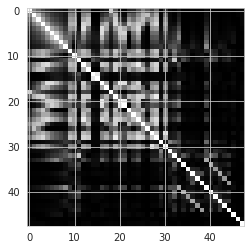

In [250]:
#heat map of spearman coefficients (absolute values)
#This code won't work until the cell that computes spearmancorrdf below is run

#heatmap from
#https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap 
plt.imshow(abs(spearmancorrdf.to_numpy()),  cmap='gray', interpolation='nearest')
plt.show()

## Forward return correlation

In [279]:
#We do the spearman correlations here


In [280]:
exogenousarray = data1.drop(columns=['ret_fwd']).to_numpy()
exogenousarray

array([[ 3.20699708e-03, -1.26255380e-02, -2.68665158e-02, ...,
         1.09717972e-02,  0.00000000e+00,  3.00000000e+00],
       [-9.29962220e-03, -2.18077475e-02, -2.18077475e-02, ...,
         1.11129542e-02,  0.00000000e+00,  4.00000000e+00],
       [-3.52009387e-03, -9.62099125e-03, -2.52510760e-02, ...,
         1.12211034e-02,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  2.56025426e-03, ...,
         7.05079860e-03,  6.00000000e+00,  3.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  2.56025426e-03, ...,
         7.05079860e-03,  6.00000000e+00,  3.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  2.56025426e-03, ...,
         7.05079860e-03,  6.00000000e+00,  3.00000000e+00]])

In [281]:
endogenousarray = data1['ret_fwd'].to_numpy()
endogenousarray

array([-0.00929962, -0.00352009,  0.00117751, ...,  0.        ,
        0.        ,  0.        ])

In [282]:
#The module is out of date with the API. The elementin the correlation object
#is now "correlation", not "statistic".
spearmancorrarray = spearmanr(exogenousarray,endogenousarray,axis=0)
spearmancorrarray.correlation.shape

(48, 48)

In [283]:
spearmancorrdf = pd.DataFrame(spearmancorrarray.correlation,
                              data1.columns)
spearmancorrdf

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
ret_01,1.000000,0.517887,0.390516,0.264103,0.182751,0.133668,0.105001,0.081911,0.053606,-0.325765,...,-0.002830,0.037218,0.002706,0.000573,-0.001709,0.007113,-0.005365,-0.001081,0.015789,-0.025929
ret_03,0.517887,1.000000,0.722689,0.483519,0.327322,0.233324,0.185899,0.141116,0.094293,-0.524002,...,-0.005570,0.065158,0.006657,0.005794,-0.003038,0.007594,-0.010637,-0.002930,0.013103,-0.024361
ret_05,0.390516,0.722689,1.000000,0.645070,0.433146,0.303143,0.242271,0.177676,0.116877,-0.617483,...,-0.007621,0.080253,0.009152,0.009226,-0.002604,0.008690,-0.013392,-0.000414,-0.000300,-0.023824
ret_10,0.264103,0.483519,0.645070,1.000000,0.636433,0.432512,0.343610,0.250529,0.159439,-0.688393,...,-0.009093,0.112251,0.012362,0.016350,-0.002200,0.010262,-0.016934,-0.005327,-0.000540,-0.023485
ret_21,0.182751,0.327322,0.433146,0.636433,1.000000,0.658521,0.528387,0.377451,0.230282,-0.610871,...,-0.006916,0.165932,0.017836,0.023403,-0.002817,0.014208,-0.023608,-0.020604,0.003232,-0.015163
ret_42,0.133668,0.233324,0.303143,0.432512,0.658521,1.000000,0.772821,0.541300,0.325273,-0.473288,...,-0.005734,0.238761,0.017731,0.030498,-0.009996,0.020167,-0.031693,-0.050853,0.001738,-0.006299
ret_63,0.105001,0.185899,0.242271,0.343610,0.528387,0.772821,1.000000,0.669693,0.414406,-0.414120,...,-0.003380,0.294655,0.015706,0.029697,-0.023375,0.026681,-0.036430,-0.064799,0.001562,-0.010579
ret_126,0.081911,0.141116,0.177676,0.250529,0.377451,0.541300,0.669693,1.000000,0.629256,-0.358246,...,0.019006,0.394323,0.006224,0.017848,-0.060312,0.044305,-0.022553,-0.072806,0.000106,0.004066
ret_252,0.053606,0.094293,0.116877,0.159439,0.230282,0.325273,0.414406,0.629256,1.000000,-0.301041,...,0.025459,0.547166,-0.025620,-0.046839,-0.110227,0.081872,0.011669,0.007288,-0.000804,-0.000259
ret_fwd,-0.325765,-0.524002,-0.617483,-0.688393,-0.610871,-0.473288,-0.414120,-0.358246,-0.301041,1.000000,...,-0.050049,-0.214406,0.186592,0.128734,0.028446,-0.078423,-0.075288,0.036757,-0.005565,0.022414


In [284]:
spearmancorrdf[9]

ret_01        -0.325765
ret_03        -0.524002
ret_05        -0.617483
ret_10        -0.688393
ret_21        -0.610871
ret_42        -0.473288
ret_63        -0.414120
ret_126       -0.358246
ret_252       -0.301041
ret_fwd        1.000000
BB_UP          0.265858
BB_LOW         0.566506
BB_SQUEEZE     0.737508
HT             0.610641
SAR            0.123228
ADX            0.084414
ADXR          -0.549759
PPO           -0.621554
AARONOSC      -0.306703
BOP           -0.774416
CCI           -0.556759
MACD          -0.403869
MACD_SIGNAL   -0.536114
MACD_HIST     -0.598473
MFI           -0.792347
RSI           -0.565469
STOCHRSI       0.217252
STOCH         -0.642353
ULTOSC        -0.764801
WILLR         -0.189630
AD            -0.544236
ADOSC         -0.178644
OBV            0.485737
ATR           -0.227969
ALPHA_63       0.176417
MARKET_63      0.091004
SMB_63         0.036679
HML_63        -0.053517
RMW_63        -0.050049
CMA_63        -0.214406
ALPHA_252      0.186592
MARKET_252     0

In [285]:
#need this down at the end of the notebook
spearmancorrdf[9].to_csv('forward_correlation.csv')

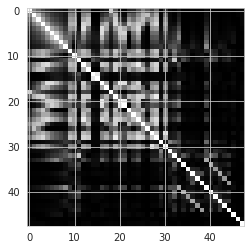

In [286]:
#heat map of spearman coefficients (absolute values)
#heatmap from
#https://stackoverflow.com/questions/33282368/plotting-a-2d-heatmap 
plt.imshow(abs(spearmancorrdf.to_numpy()),  cmap='gray', interpolation='nearest')
plt.show()

Which features are most correlated with the forward returns?

In [15]:
#Based on the correlations generated much later in this notebook, the most significant
#correlations are (abs(corr) >= 0.5):
#MFI	-0.792347148865038  Money Flow Indicator
#BOP	-0.774416299230585  Balance of Power
#ULTOSC	-0.764801112603398   Ultimate Oscillator
#BB_SQUEEZE	0.737508457252953  Bollinger Band middle band
#ret_10	-0.688392780442308   Lagged-by-10 return
#STOCH	-0.64235323464769    Stochastic
#PPO	-0.621554208672223   Percentage Price oscillator
#ret_05	-0.617483022767563   lagged-by-5 return
#ret_21	-0.610870875632917   lagged-by-21 return
#HT	0.610641324923052        Hilbert Transform
#MACD_HIST	-0.598472720866223   Moving Average Convergence/Divergence Histogram
#BB_LOW	0.566505745834939     Bollinger Band low band
#RSI	-0.565468931820442    Relative Strength Index
#CCI	-0.556758722594678    Commodity Channel Index
#ADXR	-0.549759276187479    Average Directional Movement Index Rating
#AD	-0.544236175590084         Average Directional Movement Index
#MACD_SIGNAL	-0.536113927114801  MACD Signal
#ret_03	-0.524002119000112    Lagged-by-3 return



## Mutual Information

Let's estimate the [mutual information](https://en.wikipedia.org/wiki/Mutual_information) between each feature and the forward returns for a non-linear measure of dependency (see scikit-learn [docs](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html) for references on computation.

> The `mutual_info_regression` can take a while, reduce the sample size as indicated below to speed up things.

In [150]:

mi1 = data1.drop(columns=['ret_fwd'])

In [151]:
mi1.shape

(1271422, 47)

In [152]:
mi2 = data1['ret_fwd']

In [154]:
mi2.shape

(1271422,)

In [155]:
mi1array= mi1.to_numpy()

In [156]:
mi1array.shape

(1271422, 47)

In [157]:
mi2array = mi2.to_numpy()

In [158]:
mi2array.shape

(1271422,)

In [159]:
miregression = mutual_info_regression(mi1array, mi2array)

In [160]:
miregression.shape

(47,)

In [289]:
#This file is needed all the way at the end of this notebook.

midf = pd.DataFrame(miregression, mi1.columns)

midf.set_axis(["MI"], axis="columns", inplace=True)

midf

,MI
ret_01,0.095536
ret_03,0.072686
ret_05,0.065875
ret_10,0.057527
ret_21,0.057258
ret_42,0.057624
ret_63,0.060414
ret_126,0.068128
ret_252,0.068052
BB_UP,0.066910


In [290]:
midf.to_csv('mutual_info.csv')

## LightGBM Feature Importance

There will be more information on using [LightGBM](https://lightgbm.readthedocs.io/en/latest/) in Milestone 3.

### Custom Time-Series Cross-Validation

See an example of how the `MultipleTimeSeriesCV` generates sequential, overlapping time periods for training and test in cells 11-13 [here](https://github.com/stefan-jansen/machine-learning-for-trading/blob/master/07_linear_models/05_predicting_stock_returns_with_linear_regression.ipynb).

In [291]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 date_idx='date',
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X, y=None, groups=None):
        """Generate the positional indices for the train-test splits for each fold"""
        unique_dates = X.index.get_level_values(self.date_idx).unique() # get unique dates
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            #NCO
            print('split, in first for loop')
            # create train/test start and end indices
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:
            #NCO
            print('split, second for loop')

            train_idx = dates[(dates[self.date_idx] > days[train_start])
                              & (dates.date <= days[train_end])].index
            test_idx = dates[(dates.date > days[test_start])
                             & (dates.date <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits


### Custom Metric for Early Stopping

We can customize how LightGBM measures cross-validation progress, and will use the information coefficient. See LightGBM [docs](https://github.com/Microsoft/LightGBM/blob/master/examples/python-guide/advanced_example.py).

> Keep in mind that early-stopping introduces lookahead bias, so do not use this to select between different model.

In [292]:
def ic_lgbm(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    is_higher_better = True # whether to maximize or minimize the metric
    metric_name = 'ic'
    ic = spearmanr(preds, train_data.get_label())[0]
    return metric_name, ic, is_higher_better 

### CV Parameters

In [293]:
categoricals = ['month', 'weekday']

In [294]:
train_length = 9 * YEAR
test_length = YEAR
n_splits = 1

In [295]:
params = dict(boosting='gbdt',
              objective='regression',
              verbose=-1,
              learning_rate=0.01,
#               device='gpu', # uncomment if using GPU
#               max_bins=63,  # uncomment if using GPU
              #metric='None')
              metric='ic') #NCO changed from "None"

In [296]:
num_boost_round = 5000

In [297]:
params

{'boosting': 'gbdt',
 'objective': 'regression',
 'verbose': -1,
 'learning_rate': 0.01,
 'metric': 'ic'}

### Create binary Datasets

See LightGBM [docs](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.Dataset.html#lightgbm.Dataset) on the `lgb.Dataset`.

In [298]:

#features == list of features, factors are the corresponding columns
lgb_data = lgb.Dataset(data1.drop(columns=['ret_fwd']),
                       label=data1['ret_fwd'], 
                       #reference=None, (this was in documentation, not in template notebook)
                      categorical_feature= categoricals,
                      free_raw_data=False)

In [299]:
lgb_data.get_label()

ticker  date      
A       2007-01-04   -0.009300
        2007-01-05   -0.003520
        2007-01-08    0.001178
        2007-01-09   -0.009115
        2007-01-10    0.000000
                        ...   
ZMH     2015-07-06    0.000000
        2015-07-07    0.000000
        2015-07-08    0.000000
        2015-07-09    0.000000
        2015-07-10    0.000000
Name: ret_fwd, Length: 1271422, dtype: float64

In [300]:
lgb_data

In [301]:
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          lookahead=1,
                          test_period_length=test_length,
                          train_period_length=train_length)

In [302]:
cv

### Cross-validation loop

In [304]:
#NCO: for some reason, the first time this cell is executed, it fails with error
#TypeError: 'NoneType' object is not iterable
#If you repeat it, it seems to work.

for train_idx, test_idx in cv.split(X=data1):
    start = time()
    lgb_train = lgb_data.subset(train_idx.tolist()).construct()
    lgb_test = lgb_data.subset(test_idx.tolist()).construct()
    evals_result = {}
    model = lgb.train(params=params,
                      train_set=lgb_train,
                      num_boost_round=num_boost_round,
                      valid_sets=[lgb_train, lgb_test],
                      valid_names=['train', 'valid'],
                      feval=ic_lgbm,
                      evals_result=evals_result,
                      early_stopping_rounds=500,
                      verbose_eval=100)
    model.save_model('lgb_model.txt')

split, in first for loop
split, second for loop
after lgb_train
after lgb_test
Training until validation scores don't improve for 500 rounds
[100]	train's ic: 0.102557	valid's ic: 0.0231116
[200]	train's ic: 0.130017	valid's ic: 0.033992
[300]	train's ic: 0.150496	valid's ic: 0.0332984
[400]	train's ic: 0.161957	valid's ic: 0.0349302
[500]	train's ic: 0.172426	valid's ic: 0.0369853
[600]	train's ic: 0.181683	valid's ic: 0.0374254
[700]	train's ic: 0.189268	valid's ic: 0.0364445
[800]	train's ic: 0.196166	valid's ic: 0.0369347
[900]	train's ic: 0.202669	valid's ic: 0.0369047
[1000]	train's ic: 0.207232	valid's ic: 0.0365502
Early stopping, best iteration is:
[565]	train's ic: 0.179311	valid's ic: 0.0376867
after lgb.train


In [204]:
#Through a bug, I discovered that leaving the ret_fwd column in the input array
#causes this function to generate totally erroneous data.


We can persist the model to generate predictions later:

In [305]:
model = lgb.Booster(model_file='lgb_model.txt')

### Generate and evaluate predictions

In [307]:
# select test features and label
test_set = data1.iloc[test_idx, :]
X_test = test_set.loc[:, model.feature_name()]
y_test = test_set.loc[:, 'ret_fwd']

# make predictions
y_pred = model.predict(X_test)
cv_preds = y_test.to_frame('y_test').assign(y_pred=y_pred)

# compute daily correlation
by_day = cv_preds.groupby(level='date')
ic_by_day = by_day.apply(lambda x: spearmanr(x.y_test, x.y_pred)[0])
daily_ic_mean = ic_by_day.mean()
daily_ic_std = ic_by_day.std()
daily_ic_median = ic_by_day.median()
ic = spearmanr(cv_preds.y_test, cv_preds.y_pred)[0]
print(f'Overall IC: {ic:6.2%} | Average Daily IC: {daily_ic_mean: 6.2%} | Coefficient of Variation for daily IC: {daily_ic_std/daily_ic_mean: 5.2} | Median Daily IC: {daily_ic_median: 6.2%}')

Overall IC:  3.77% | Average Daily IC:  2.64% | Coefficient of Variation for daily IC:   5.6 | Median Daily IC:  2.38%


While the daily average of the IC is positive at 0.028, it is also quite volatile. In other words, predictions will do quite poorly occasionally (and much better otherwise).

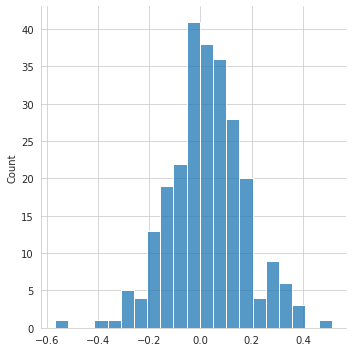

In [308]:
sns.displot(ic_by_day);

Higher momemts (Skew and Kurtosis) confirm that, while only slightly negatively skewed, but has significantly fatter tails than a normal distribution (pandas uses [Fisher's definition](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.kurtosis.html)).

In [309]:
pd.Series({'Mean': ic_by_day.mean(), 
           'Std. Dev': ic_by_day.std(), 
           'Median': ic_by_day.median(), 
           'Skew': ic_by_day.skew(), 
           'Kurtosis': ic_by_day.kurtosis()}).apply(lambda x: f'{x:.4f}')

Mean         0.0264
Std. Dev     0.1483
Median       0.0238
Skew        -0.0682
Kurtosis     1.0991
dtype: object

### Compute Feature Importance

In [310]:
def get_fi(model):
    """Compute LightGBM feature imporance"""
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))

In [311]:
fi = get_fi(model)
fi.to_csv('feature_importance.csv')

In [312]:
cv_result = pd.DataFrame({'Train Set': evals_result['train']['ic'], 
                          'Validation Set': evals_result['valid']['ic']})

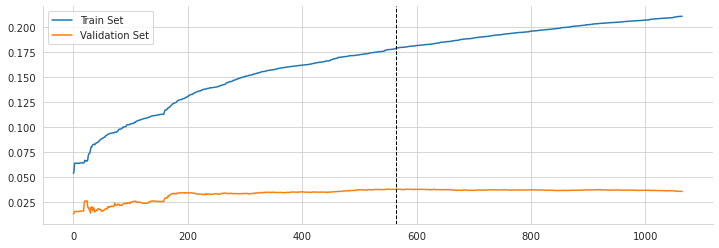

In [313]:
ax = cv_result.plot(figsize=(12, 4))
ax.axvline(cv_result['Validation Set'].idxmax(), c='k', ls='--', lw=1)
sns.despine();

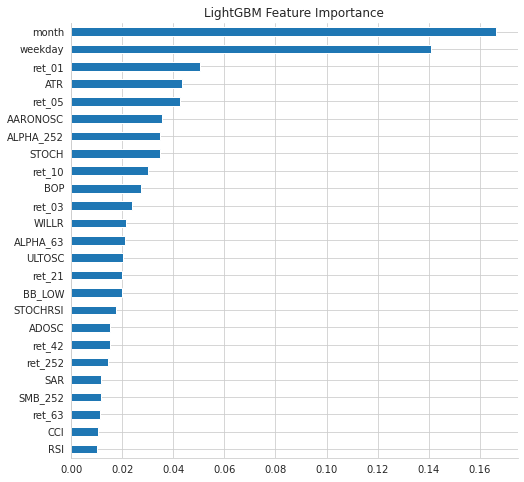

In [546]:
#without dropping categoricals
fi.nlargest(25).sort_values().plot.barh(figsize=(8, 8),
                                        title='LightGBM Feature Importance')
sns.despine();

## SHAP Values

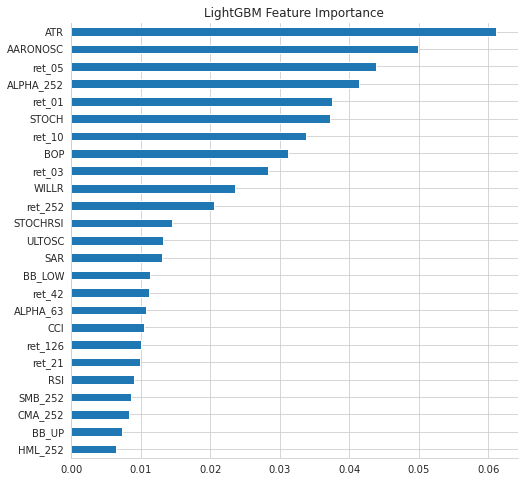

In [314]:
#dropping categoricals
#Categoricals in this data set are month and weekday, which were added from the Fama/French
#features.
fi.drop(categoricals).nlargest(25).sort_values().plot.barh(figsize=(8, 8),
                                        title='LightGBM Feature Importance')
sns.despine();

See SHAP Values [GitHub repo](https://github.com/slundberg/shap) for docs and links to papers.

In [315]:
shap.initjs()

In [316]:
model = lgb.Booster(model_file='lgb_model.txt')

In [317]:
explainer = shap.TreeExplainer(model)

In [318]:
# workaround for SHAP version 0.35: https://github.com/slundberg/shap/issues/794
model.params['objective'] = 'regression'

In [319]:
shap_values = explainer.shap_values(data1.drop(columns=['ret_fwd']).iloc[test_idx, :].loc[:, model.feature_name()])
#factors --> data1.drop(columns=['ret_fwd'])

In [320]:
shap_values

array([[-8.00368007e-06, -3.42647413e-05, -9.17070340e-05, ...,
         1.61160992e-06,  7.35348355e-04, -1.54996081e-05],
       [-6.36491795e-05,  1.96127890e-05, -6.78554540e-05, ...,
         7.98222662e-07, -4.93517355e-04,  3.72823653e-04],
       [-5.43867437e-05,  1.28862485e-05, -3.08844791e-05, ...,
         4.90707181e-07, -3.45613603e-04,  5.36498243e-05],
       ...,
       [-3.61012343e-05, -2.48875288e-05, -3.68247803e-05, ...,
         2.71016102e-07,  6.96446864e-04, -7.13210862e-05],
       [-1.02456600e-04, -2.41157498e-05, -8.12410560e-05, ...,
        -8.58822955e-09,  6.07111512e-04,  2.90201417e-05],
       [-8.56272971e-05, -2.43199085e-05, -7.30952048e-05, ...,
        -1.09770889e-06,  7.19121187e-04, -2.56758716e-05]])

In [321]:
np.save('shap_values.npy', shap_values)

In [322]:
#skipping for debug purposes because we just computed them
#shap_values = np.load('shap_values.npy')

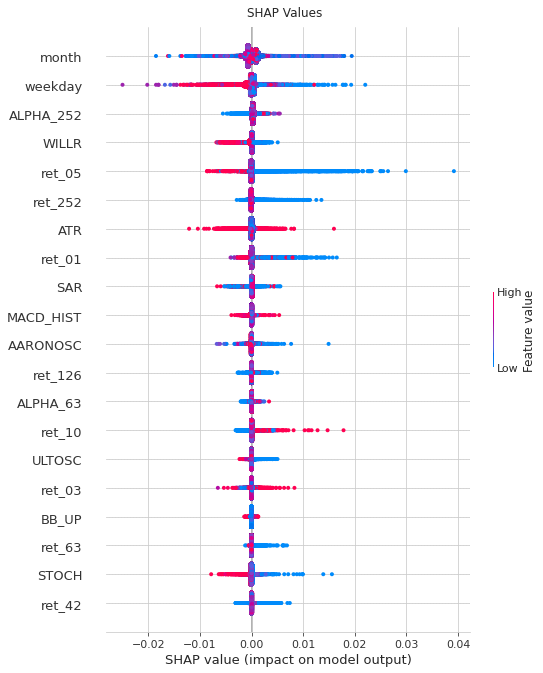

In [323]:
shap.summary_plot(shap_values,
                  data1.drop(columns=['ret_fwd'])
                  .iloc[test_idx, :]
                  .loc[:, model.feature_name()],
                  show=False)

plt.gcf().suptitle('SHAP Values')
plt.gcf().tight_layout()

In [324]:
shap_values = pd.DataFrame(shap_values, columns=features1)

In [325]:
shap_summary = np.abs(shap_values).mean()
shap_summary /= shap_summary.sum()

In [326]:
shap_summary.nlargest(20)

month        0.236353
weekday      0.150218
ALPHA_252    0.089279
WILLR        0.056617
ret_05       0.049069
ret_252      0.043276
ATR          0.041840
ret_01       0.030203
SAR          0.029565
MACD_HIST    0.022717
AARONOSC     0.017318
ret_126      0.016845
ALPHA_63     0.015820
ret_10       0.015687
ULTOSC       0.015580
ret_03       0.015112
BB_UP        0.014966
ret_63       0.012824
STOCH        0.012048
ret_42       0.011916
dtype: float64

In [328]:
shap_summary.to_csv('shap_values.csv')

## Comparison

In [329]:
mi = pd.read_csv('mutual_info.csv', index_col=0, squeeze=True)
fwd_corr = pd.read_csv('forward_correlation.csv', index_col=0, squeeze=True)

In [330]:
fwd_corr

ret_01        -0.325765
ret_03        -0.524002
ret_05        -0.617483
ret_10        -0.688393
ret_21        -0.610871
ret_42        -0.473288
ret_63        -0.414120
ret_126       -0.358246
ret_252       -0.301041
ret_fwd        1.000000
BB_UP          0.265858
BB_LOW         0.566506
BB_SQUEEZE     0.737508
HT             0.610641
SAR            0.123228
ADX            0.084414
ADXR          -0.549759
PPO           -0.621554
AARONOSC      -0.306703
BOP           -0.774416
CCI           -0.556759
MACD          -0.403869
MACD_SIGNAL   -0.536114
MACD_HIST     -0.598473
MFI           -0.792347
RSI           -0.565469
STOCHRSI       0.217252
STOCH         -0.642353
ULTOSC        -0.764801
WILLR         -0.189630
AD            -0.544236
ADOSC         -0.178644
OBV            0.485737
ATR           -0.227969
ALPHA_63       0.176417
MARKET_63      0.091004
SMB_63         0.036679
HML_63        -0.053517
RMW_63        -0.050049
CMA_63        -0.214406
ALPHA_252      0.186592
MARKET_252     0

In [331]:
stats = (mi.to_frame('Mutual Information')
         .join(fwd_corr.to_frame('Information Coefficient'))
         .join(fi.to_frame('Feature Importance'))
         .join(shap_summary.to_frame('SHAP Values')))

In [332]:
stats

,Mutual Information,Information Coefficient,Feature Importance,SHAP Values
ret_01,0.095536,-0.325765,0.037497,0.030203
ret_03,0.072686,-0.524002,0.028344,0.015112
ret_05,0.065875,-0.617483,0.043842,0.049069
ret_10,0.057527,-0.688393,0.033833,0.015687
ret_21,0.057258,-0.610871,0.009886,0.003847
ret_42,0.057624,-0.473288,0.011209,0.011916
ret_63,0.060414,-0.414120,0.006333,0.012824
ret_126,0.068128,-0.358246,0.010080,0.016845
ret_252,0.068052,-0.301041,0.020594,0.043276
BB_UP,0.066910,0.265858,0.007322,0.014966


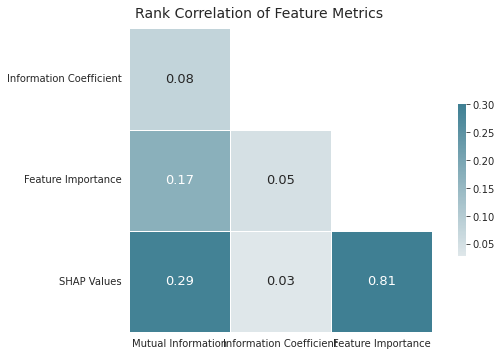

In [333]:
cols = {'Information Coefficient': stats['Information Coefficient'].abs()}

corr = stats.assign(**cols).corr('spearman')

mask = np.triu(np.ones_like(corr, dtype=np.bool))
corr = corr.iloc[1:, :-1]
mask = mask[1:, :-1]

fig, ax = plt.subplots(figsize=(8, 5))

cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.heatmap(corr, mask=mask,
            cmap=cmap,
            vmax=.3, center=0,
            square=True, linewidths=.5,
            cbar_kws={"shrink": .5},
            annot=True, fmt='.2f',
            annot_kws={"size": 13})

plt.xticks(rotation=0)
fig.suptitle('Rank Correlation of Feature Metrics', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.92)

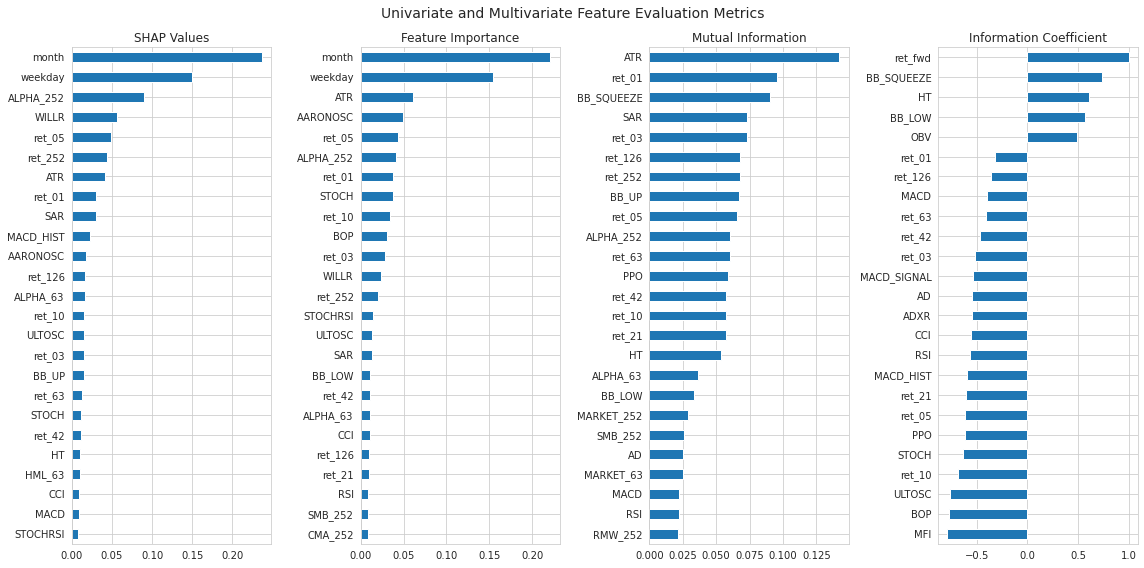

In [338]:
top_n = 25
fig, axes = plt.subplots(ncols=4, figsize=(16, 8))

shap_summary.nlargest(top_n).sort_values().plot.barh(ax=axes[0], title='SHAP Values')

fi.nlargest(top_n).sort_values().plot.barh(ax=axes[1], title='Feature Importance')

mi.nlargest(top_n).sort_values().plot.barh(ax=axes[2], title='Mutual Information')

top_corr = fwd_corr.abs().nlargest(top_n).index
fwd_corr.loc[top_corr].sort_values().plot.barh(ax=axes[3], title='Information Coefficient')

fig.suptitle('Univariate and Multivariate Feature Evaluation Metrics', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.91);

In [334]:
corr

,Mutual Information,Information Coefficient,Feature Importance
Information Coefficient,0.078400,1.000000,0.046832
Feature Importance,0.173104,0.046832,1.000000
SHAP Values,0.292438,0.028793,0.807586


In [339]:
top_ranked = stats.drop('Mutual Information', axis=1).abs().rank(ascending=False).mean(1)

In [340]:
top_ranked.to_csv('top_features.csv')

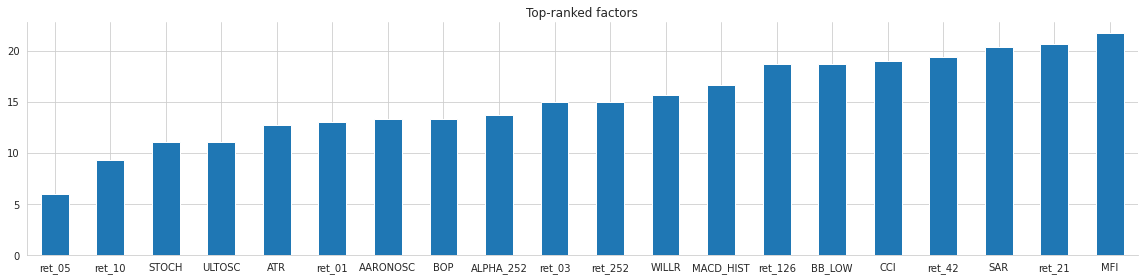

In [341]:
top_ranked.drop(categoricals).nsmallest(20).plot.bar(figsize=(16, 4), rot=0, title='Top-ranked factors')
sns.despine()
plt.tight_layout();

## Alphalens Analysis

Alphalens is a Python Library (originally developed by Quantopian) for performance analysis of predictive (alpha) stock factors. Alphalens works great with the Zipline open source backtesting library, and Pyfolio which provides performance and risk analysis of financial portfolios. 

The main function of Alphalens is to surface the most relevant statistics and plots about an alpha factor, including:

- Returns Analysis
- Information Coefficient Analysis
- Turnover Analysis
- Grouped Analysis

See Alphalens [docs](https://alphalens.ml4trading.io) and [example notebooks](https://github.com/stefan-jansen/alphalens-reloaded/tree/master/alphalens/examples) for additional detail.

In [239]:
tickers = data1.index.unique('ticker') #factors --> data1

### Get trade prices

We need market prices for the relevant period:

In [342]:
def get_trade_prices(tickers):
    return (pd.read_hdf(DATA_STORE, 'us_stocks')
              .loc[idx[tickers, '2006':'2017'], 'open']
              .unstack('ticker')
              .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

In [343]:
trade_prices = get_trade_prices(tickers)

In [344]:
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3020 entries, 2006-01-03 00:00:00+00:00 to 2017-12-29 00:00:00+00:00
Columns: 500 entries, A to ZMH
dtypes: float64(500)
memory usage: 11.5 MB


### Select factor

We also need the factor signals that we want to evaluate:

In [345]:
alpha = 'ATR'

In [346]:
factor = (data1[alpha] #factors --> data1
          .unstack('ticker')
          .stack()
          .tz_localize('UTC', level='date')
          .sort_index())

In [347]:
factor

date                       ticker
2007-01-04 00:00:00+00:00  A         0.023575
                           AAL       0.046281
                           AAP       0.020229
                           AAPL      0.031985
                           ABC       0.015507
                                       ...   
2016-12-29 00:00:00+00:00  XRX       0.019299
                           YHOO      0.019236
                           YUM       0.010521
                           ZBH       0.017878
                           ZION      0.022474
Length: 1271422, dtype: float64

### Generate Alphalens input data

With a signal and pricing data creating a factor "tear sheet" is a two step process:
1. Bring data into the right format
2. Select desired tearsheet.

In [247]:
factor_data = utils.get_clean_factor_and_forward_returns(factor=factor,#d (typo in notebook?)
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   max_loss=0.35,
                                                   periods=(1, 5, 10)).sort_index()
factor_data.info()

Dropped 2.6% entries from factor data: 2.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1238685 entries, (Timestamp('2007-01-04 00:00:00+0000', tz='UTC', freq='C'), 'A') to (Timestamp('2016-12-29 00:00:00+0000', tz='UTC', freq='C'), 'ZION')
Data columns (total 5 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   1D               1238685 non-null  float64
 1   5D               1238685 non-null  float64
 2   11D              1238685 non-null  float64
 3   factor           1238685 non-null  float64
 4   factor_quantile  1238685 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 52.1+ MB


### Create Tearsheet

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,0.000642,0.076998,0.017676,0.008437,248303,20.045694
2,0.011341,0.092646,0.022977,0.010960,247520,19.982481
3,0.013174,0.109388,0.027532,0.013684,247291,19.963994
4,0.015579,0.139410,0.033293,0.017085,247520,19.982481
5,0.019018,1.141389,0.049059,0.031558,248051,20.025349


Returns Analysis


,1D,5D,11D
Ann. alpha,-0.026,-0.028,-0.026
beta,0.510,0.545,0.537
Mean Period Wise Return Top Quantile (bps),1.849,1.677,1.361
Mean Period Wise Return Bottom Quantile (bps),-1.650,-1.506,-1.300
Mean Period Wise Spread (bps),3.499,2.965,2.464


Information Analysis


,1D,5D,11D
IC Mean,-0.012,-0.006,-0.002
IC Std.,0.258,0.264,0.252
Risk-Adjusted IC,-0.045,-0.023,-0.009
t-stat(IC),NaN,NaN,NaN
p-value(IC),NaN,NaN,NaN
IC Skew,NaN,NaN,NaN
IC Kurtosis,NaN,NaN,NaN


Turnover Analysis


,1D,5D,11D
Quantile 1 Mean Turnover,0.048,0.124,0.184
Quantile 2 Mean Turnover,0.110,0.279,0.399
Quantile 3 Mean Turnover,0.122,0.312,0.439
Quantile 4 Mean Turnover,0.100,0.261,0.378
Quantile 5 Mean Turnover,0.040,0.106,0.159


,1D,5D,11D
Mean Factor Rank Autocorrelation,0.995,0.97,0.938


<Figure size 432x288 with 0 Axes>

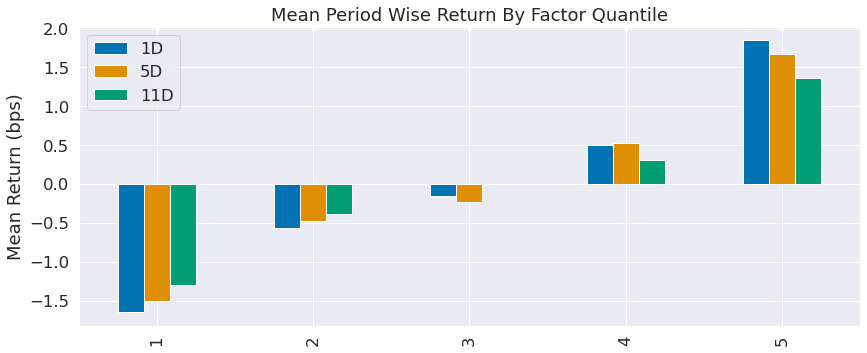

In [248]:
create_summary_tear_sheet(factor_data)